In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

In [2]:
links = pd.read_csv('../data/ml-latest-small/links.csv')
movies = pd.read_csv('../data/ml-latest-small/movies.csv')
ratings = pd.read_csv('../data/ml-latest-small/ratings.csv')
tags = pd.read_csv('../data/ml-latest-small/tags.csv')

In [3]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [7]:
# соединим таблицу с рейтингами и названиями фильмов
joined_ratings = ratings.join(movies.set_index('movieId'), on='movieId')

In [8]:
joined_ratings.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


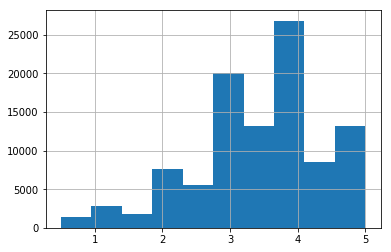

In [9]:
# посмотрим на гистограмму распределения оценок
joined_ratings.rating.hist()

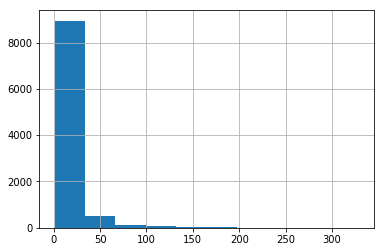

In [10]:
# гистограмма по количеству оценок на фильм
joined_ratings.groupby('title').rating.count().hist()

In [26]:
# достанем топ фильмов по оценкам
top_films = joined_ratings.groupby('title')[['rating']].mean().sort_values('rating', ascending=False)
top_films.head(10)

,rating
title,
Gena the Crocodile (1969),5.0
True Stories (1986),5.0
Cosmic Scrat-tastrophe (2015),5.0
Love and Pigeons (1985),5.0
Red Sorghum (Hong gao liang) (1987),5.0
"Thin Line Between Love and Hate, A (1996)",5.0
Lesson Faust (1994),5.0
Eva (2011),5.0
Who Killed Chea Vichea? (2010),5.0


In [12]:
# возьмем только фильмы с наивысшей средней оценкой в 5.0
films_with_highest_marks = top_films.iloc[np.where(top_films.rating == 5.0)].index

In [13]:
# достанем по каждому фильму количество рейтингов
title_num_ratings = {}

for title, group in tqdm_notebook(joined_ratings.groupby('title')):
    title_num_ratings[title] = group.userId.unique().shape[0]

In [14]:
# выведем топ фильмов со средней оценкой в 5.0 по количеству отзывов и увидим, что рейтинг получается не самый удачный
sorted([(title_num_ratings[f], f) for f in films_with_highest_marks], key=lambda x: x[0], reverse=True)[:10]

[(2, 'Lesson Faust (1994)'),
 (2, 'Heidi Fleiss: Hollywood Madam (1995)'),
 (2, 'Enter the Void (2009)'),
 (2, 'Lamerica (1994)'),
 (2,
  "Jonah Who Will Be 25 in the Year 2000 (Jonas qui aura 25 ans en l'an 2000) (1976)"),
 (2, 'Come and See (Idi i smotri) (1985)'),
 (2, 'Belle époque (1992)'),
 (1, 'Gena the Crocodile (1969)'),
 (1, 'True Stories (1986)'),
 (1, 'Cosmic Scrat-tastrophe (2015)')]

### Приняли решение сортировать фильмы по следующей метрике: средняя оценка фильма, умноженная на нормированное количество рейтингов

In [15]:
# достанем простые статистики по количеству рейтингов
min_num_ratings = np.min([title_num_ratings[f] for f in title_num_ratings.keys()])
max_num_ratings = np.max([title_num_ratings[f] for f in title_num_ratings.keys()])
mean_num_ratings = np.mean([title_num_ratings[f] for f in title_num_ratings.keys()])
median_num_ratings = np.median([title_num_ratings[f] for f in title_num_ratings.keys()])

In [16]:
print(min_num_ratings)
print(max_num_ratings)
print(mean_num_ratings)
print(median_num_ratings)

1
329
10.374729910484618
3.0


In [17]:
# считаем средний рейтинг на каждый фильм
title_mean_rating = {}

for title, group in tqdm_notebook(joined_ratings.groupby('title')):
    title_mean_rating[title] = group.rating.mean()

In [18]:
film_with_our_mark = []

# посчитаем нашу метрику для каждого фильма из датасета
for f in title_num_ratings.keys():
    film_with_our_mark.append(
        (f, title_mean_rating[f] * (title_num_ratings[f] - mean_num_ratings) / (max_num_ratings - min_num_ratings))
    )

In [19]:
# выводим топ 20 и получилось уже очень неплохо
list(sorted(film_with_our_mark, key=lambda x: x[1], reverse=True))[:20]

[('Shawshank Redemption, The (1994)', 4.140396622352077),
 ('Forrest Gump (1994)', 4.04511657667948),
 ('Pulp Fiction (1994)', 3.795599234431761),
 ('Matrix, The (1999)', 3.4207454409691413),
 ('Silence of the Lambs, The (1991)', 3.4080113927564395),
 ('Star Wars: Episode IV - A New Hope (1977)', 3.103974793934813),
 ('Braveheart (1995)', 2.7855877015865484),
 ('Fight Club (1999)', 2.7047848943888955),
 ("Schindler's List (1993)", 2.7002035552689096),
 ('Jurassic Park (1993)', 2.6024230574258618),
 ('Terminator 2: Judgment Day (1991)', 2.5862869902088406),
 ('Star Wars: Episode V - The Empire Strikes Back (1980)', 2.5785484011187134),
 ('Usual Suspects, The (1995)', 2.5016296926169597),
 ('Toy Story (1995)', 2.4461018531687673),
 ('Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)',
  2.4324644021391335),
 ('American Beauty (1999)', 2.394561678011029),
 ('Godfather, The (1972)', 2.375006509125951),
 ('Lord of the Rings: The Fellowship of the Ring, The (2001

### Появилась гипотеза использовать теги в ранжировании фильмов, решили считать не только количество отзывов, а ещё и количество проставленных тегов на фильм

In [20]:
# соединим уже созданную таблицу с таблицей с проставленными тегами по фильмам
joined_with_tags = joined_ratings.join(tags.set_index('movieId'), on='movieId', lsuffix='_left', rsuffix='_right')

In [21]:
# достанем по каждому фильму количество рейтингов
title_num_actions = {}

for title, group in tqdm_notebook(joined_with_tags.groupby('title')):
    title_num_actions[title] = group.shape[0]

In [22]:
min_num_actions = np.min([title_num_actions[f] for f in title_num_actions.keys()])
max_num_actions = np.max([title_num_actions[f] for f in title_num_actions.keys()])
mean_num_actions = np.mean([title_num_actions[f] for f in title_num_actions.keys()])
median_num_actions = np.median([title_num_actions[f] for f in title_num_actions.keys()])

In [23]:
print(min_num_actions)
print(max_num_actions)
print(mean_num_actions)
print(median_num_actions)

1
55567
29.40240765510855
3.0


In [24]:
film_with_new_mark = []

for f in title_num_actions.keys():
    # посчитаем нашу новую метрику для каждого фильма из датасета
    film_with_new_mark.append(
        (f, title_mean_rating[f] * (title_num_actions[f] - mean_num_ratings) / (max_num_ratings - min_num_ratings))
    )

In [25]:
# выведем топ фильмов по новой метрике
list(sorted(film_with_new_mark, key=lambda x: x[1], reverse=True))[:20]

[('Pulp Fiction (1994)', 710.8992577710171),
 ('Fight Club (1999)', 153.2215531870718),
 ('Star Wars: Episode IV - A New Hope (1977)', 84.04909674515433),
 ('Léon: The Professional (a.k.a. The Professional) (Léon) (1994)',
  56.907945325115676),
 ('Eternal Sunshine of the Spotless Mind (2004)', 56.36231084059733),
 ('2001: A Space Odyssey (1968)', 52.93931604254306),
 ('Inception (2010)', 45.965889786735744),
 ('Big Lebowski, The (1998)', 40.46123194768863),
 ('Donnie Darko (2001)', 38.24601049504502),
 ('Forrest Gump (1994)', 37.459750723020946),
 ('Braveheart (1995)', 29.003575506464596),
 ('Star Wars: Episode V - The Empire Strikes Back (1980)', 26.985560596240664),
 ('Memento (2000)', 25.84978264579838),
 ('Lord of the Rings: The Return of the King, The (2003)', 23.101424782600702),
 ('Terminator 2: Judgment Day (1991)', 21.569518697525915),
 ('Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 21.367917448896037),
 ('Silence of the Lambs, The (1991)', 21.106182124463757),
 ('Raiders of t